In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

In [197]:
train = pd.read_csv("train.csv", index_col=0)

In [59]:
train = pd.read_csv("train.csv", index_col=0)

## PreProcessing

In [209]:
def start_pipe(df):
    return df.copy()

In [210]:
def create_weekday_column(df):
    df["Weekday"] = df["Date"].apply(lambda d: datetime.strptime(d.split(" ")[0], "%m/%d/%Y").strftime('%A'))
    df = df.join(pd.get_dummies(train_["Weekday"], drop_first=True))
    return df

In [217]:
def create_time_bins(df):
    df["am_pm"] = df["Date"].apply(lambda d: d.split(" ")[2].strip(" ")).apply(lambda d: 1 if d == "AM" else 0)
    df["hour"] = df["Date"].apply(lambda d: d.split(" ")[1].split(":")[0])
    df["24_h"] = df.apply(lambda row: int(row["hour"]) if row["am_pm"] == 1 else int(row["hour"]) + 12, axis=1)
    df = df.join(pd.get_dummies(train_["24_h"], drop_first=True, prefix="_h"))
    return df

In [212]:
def create_decription_bins(df):
    value_list = df["Location Description"].value_counts()[:25].index.tolist()
    df["Location Decsription"] = train.apply(lambda row: row["Location Description"] if row["Location Description"] in (value_list) else "OTHER", axis=1)
    return df

In [ ]:
def create_district_bins(df):
    df["Dist_Partition"] = pd.qcut(df['District'], 10, labels=range(1,11))
    df = df.join(pd.get_dummies(df["Dist_Partition"], drop_first=True, prefix='_dist'))
    return df

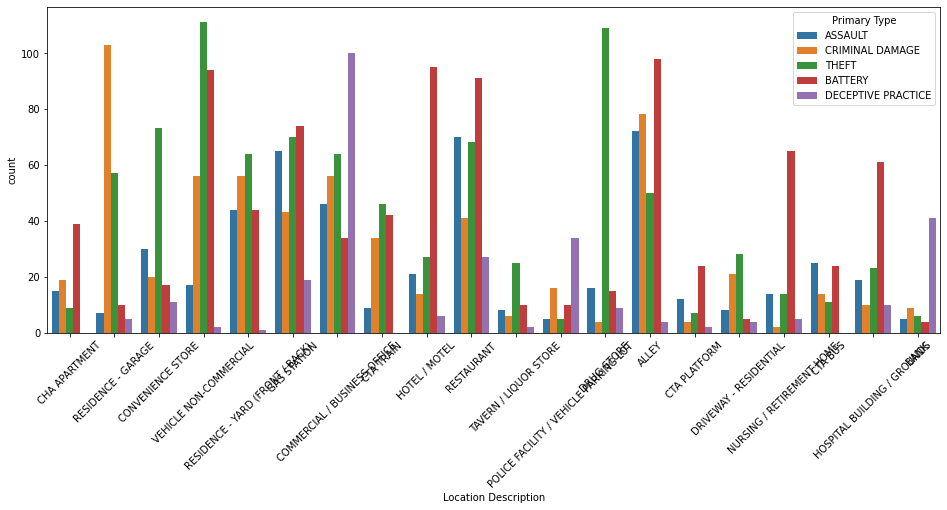

In [175]:

plt.figure(figsize=(16, 6))
sns.countplot(data = test, x="Location Description", hue="Primary Type")
plt.xticks(rotation=45)
plt.show()

<AxesSubplot:>

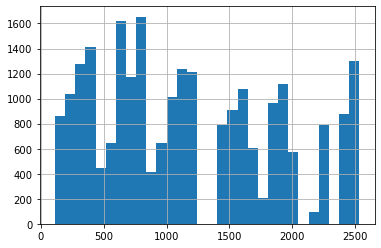

In [73]:
train["Beat"].hist(bins=30)

<AxesSubplot:xlabel='AM_PM', ylabel='count'>

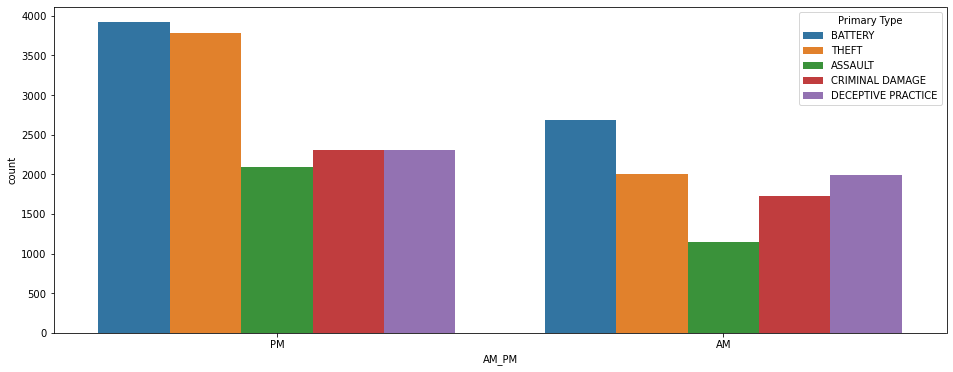

In [58]:
plt.figure(figsize=(16, 6))
sns.countplot(x="AM_PM",hue="Primary Type", data=train)

<AxesSubplot:xlabel='Weekday', ylabel='count'>

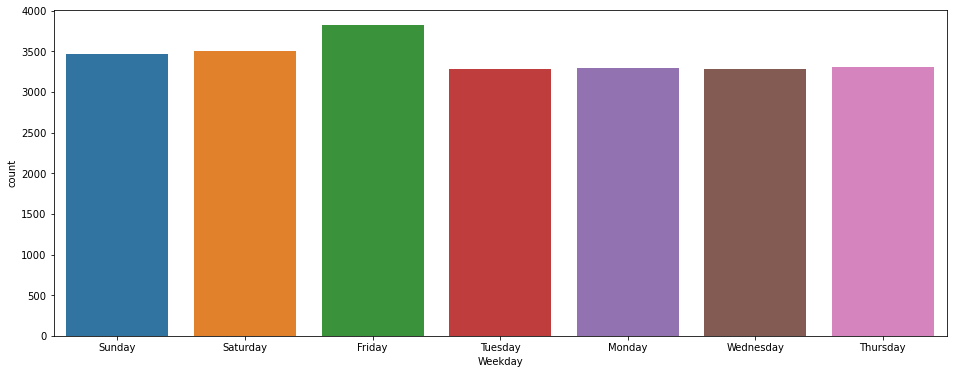

In [46]:
plt.figure(figsize=(16, 6))
sns.countplot(x="Weekday", data=train)

KeyboardInterrupt: 

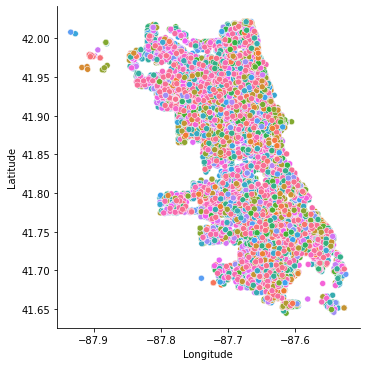

In [20]:
sns.relplot(x="Longitude", y="Latitude", hue="Block", data=train)

<AxesSubplot:xlabel='Beat', ylabel='count'>

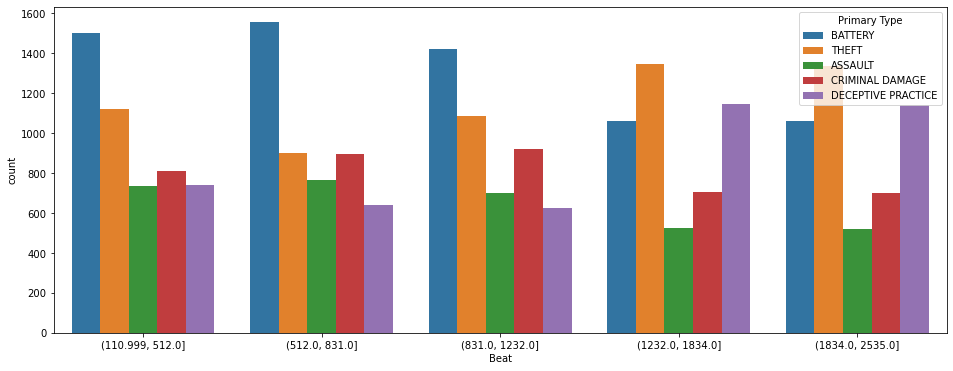

In [112]:

plt.figure(figsize=(16, 6))
sns.countplot(x=pd.qcut(train["Beat"], 5), hue=train["Primary Type"])

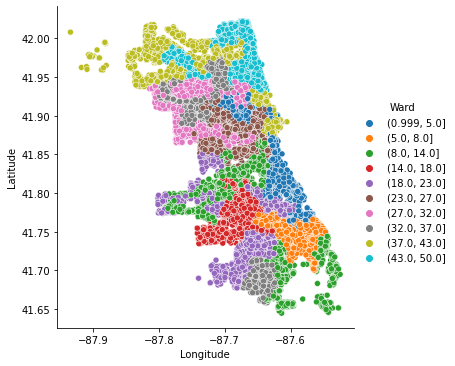

In [115]:
sns.relplot( x=train["Longitude"], y=train["Latitude"], hue=pd.qcut(train["Ward"], 10))

<AxesSubplot:xlabel='24_h', ylabel='count'>

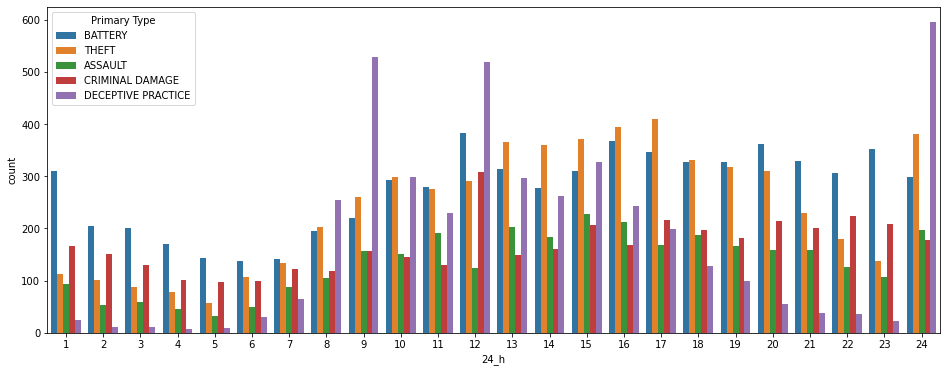

In [121]:
plt.figure(figsize=(16, 6))
sns.countplot(data=train, x="24_h", hue="Primary Type")